In [5]:
!which python

/home/asa/miniconda3/envs/PyTorch-Development/bin/python


## Univariate LSTM model using the torch

In [19]:
# Importing the Required Packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.utils.data as torch_data

In [20]:
# Checking GPU Availability

if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name()}")
else:
    print(f"device: {str(torch.device('cpu')).upper()}")
    print("CUDA is not available. No GPU detected.")

GPU device: NVIDIA GeForce RTX 4050 Laptop GPU


In [21]:
# Loading and Inspecting the Data

data = pd.read_csv('./data1.csv')

# data_info = data.info()
data_description = data.describe()

data_head = data.head(10)

data_shape = data.shape
data_size = data.size

data = pd.DataFrame(data, columns=['timestamp', 'worst'])

data.head()

,timestamp,worst
0,0.00000,-0.026883
1,0.00004,-0.064800
2,0.00008,-0.151000
3,0.00012,-0.143051
4,0.00016,-0.050299


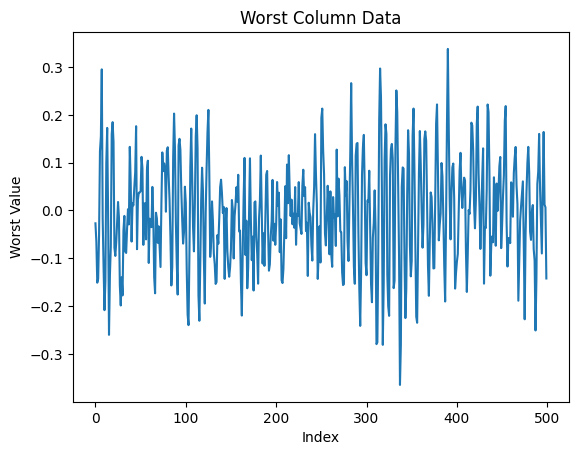

In [22]:
# Visualizing the Data

worst = data['worst']

worst_shape = worst.shape
worst_size = worst.size


# Plotting the first 500 data points
plt.plot(worst[:500])
plt.title('Worst Column Data')
plt.xlabel('Index')
plt.ylabel('Worst Value')
plt.show()

In [23]:
# Data Preprocessing

# Checking for null values
null_values = worst[worst.isnull()]
null_values_shape = null_values.shape
null_values_sum = null_values.sum()

# Checking for any null values
has_nulls = worst.isnull().values.any()

# Splitting the train and test data
total_size = worst.size
train_size = int(total_size * 0.6)
test_size = total_size - train_size

worst_train = worst[:train_size]
worst_test = worst[train_size:]

# Displaying shapes of train and test data
worst_train_shape = worst_train.shape
worst_test_shape = worst_test.shape

In [24]:
# Creating the Dataset for Training

def create_dataset(dataset, loopback):
    X, y = [], []
    for i in range(len(dataset) - loopback):
        feature = dataset.iloc[i:i+loopback].values
        target = dataset.iloc[i+1:i+loopback+1].values
        X.append(feature)
        y.append(target)
    X = np.array(X)
    y = np.array(y)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Create the dataset
lookback = 1
X_train, y_train = create_dataset(dataset=worst_train, loopback=lookback)
X_test, y_test = create_dataset(dataset=worst_test, loopback=lookback)

# Displaying shapes of datasets
X_train_shape = X_train.shape
y_train_shape = y_train.shape
X_test_shape = X_test.shape
y_test_shape = y_test.shape

In [25]:
# Defining and Training the LSTM Model

# Defining the LSTM model
class TiModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [26]:
# Initializing the model
model = TiModel()
optimizer = Adam(model.parameters())
loss_fn = nn.MSELoss()

# Creating the DataLoader
loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=False, batch_size=8)

In [14]:
# Training loop
n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred_train, y_train))
            y_pred_test = model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred_test, y_test))
        print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

# Saving the model
torch.save(model.state_dict(), 'lstm_worst_predictor.pth')

Epoch 0: train RMSE 0.0773, test RMSE 0.0785
Epoch 10: train RMSE 0.0892, test RMSE 0.0903


/tmp/ipykernel_30680/3920346098.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lstm_worst_predictor.pth'))


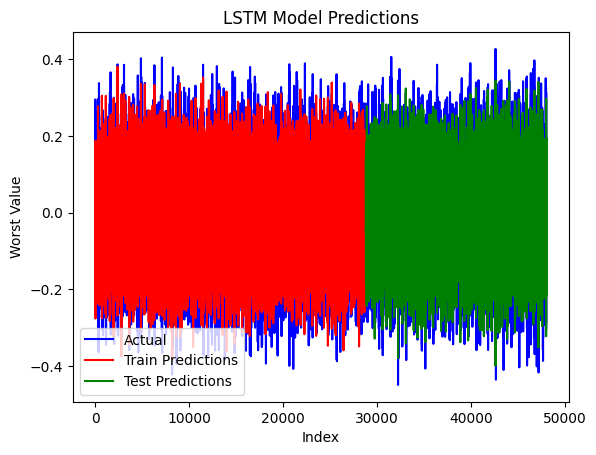

In [27]:
# Loading the Model and Plotting the Results

# Loading the saved model
model = TiModel()
model.load_state_dict(torch.load('lstm_worst_predictor.pth'))
model.eval()

with torch.no_grad():
    # Shift train predictions for plotting
    train_plot = np.ones_like(worst) * np.nan
    y_pred_train = model(X_train)
    train_plot[lookback:train_size] = y_pred_train[:, -1].numpy()

    # Shift test predictions for plotting
    test_plot = np.ones_like(worst) * np.nan
    y_pred_test = model(X_test)
    test_plot[train_size + lookback:] = y_pred_test[:, -1].numpy()

# Plotting the results
plt.plot(worst, c='b', label='Actual')
plt.plot(train_plot, c='r', label='Train Predictions')
plt.plot(test_plot, c='g', label='Test Predictions')
plt.legend()
plt.title('LSTM Model Predictions')
plt.xlabel('Index')
plt.ylabel('Worst Value')
plt.show()